# Training-job-for-SageMaker

**Note**: To run this example training job, you must be in `us-west-2`. The preview version of container images are available only in those two regions.

## Install and Upgrade Libraries

The SageMaker model parallelism library's tensor parallelism feature requires the SageMaker Python SDK and the SageMaker Experiments library. Run the following cell to install or upgrade the libraries.

**Note:** To finish applying the changes, you must restart the kernel.

Import and check if the SageMaker Python SDK version is successfully set to the latest version

In [2]:
install_needed = True  # should only be True once
# install_needed = False

In [3]:
%%bash
#!/bin/bash

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

Already revised


In [4]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U smdebug sagemaker-experiments
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U datasets transformers
    !{sys.executable} -m pip install -U wget omegaconf text-unidecode
    ## Install NeMo
    BRANCH = 'main'
    !{sys.executable} -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
    !pip install --upgrade --force-reinstall llvmlite
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Attempting uninstall: omegaconf
    Found existing installation: omegaconf 2.2.3
    Uninstalling omegaconf-2.2.3:
      Successfully uninstalled omegaconf-2.2.3
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-lz5pij5r/nemo-toolkit_51b8e70a6ffd468096176d71205450ee
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-lz5pij5r/nemo-toolkit_51b8e70a6ffd468096176d71205450ee
  Resolved https://gi

## Amazon SageMaker Initialization

This private preview feature is available to use in `us-east-1` and `us-west-2`.
Throughout this example, you'll use a training script of GPT model and a text dataset.

Run the following cell to import SageMaker modules and retrieve information of your current SageMaker work environment: your AWS account ID, the AWS Region you are using to run the notebook, and the ARN of your Amazon SageMaker execution role.

## Finetuning CTC models on other languages

In previous tutorials, we have seen a few ways to restore an ASR model, set up the data loaders, and then either train from scratch or fine-tune the model on a small dataset. In this tutorial, we extend previous tutorials and discuss in detail how to * fine-tune a pre-trained model onto a new language*. While many of the concepts are similar to previous tutorials, this tutorial will dive deeper into essential steps. Namely,

 - Data preprocessing
 - Prepare tokenizers
 - Discuss how to fine-tune models on low-resource languages efficiently
 - Train a character encoding CTC model
 - Train a sub-word encoding CTC model

For this tutorial (and limited by the compute and storage available on Colab environments), we will attempt to fine-tune an English ASR model onto the [Mozilla Common Voice](https://commonvoice.mozilla.org/en) dataset for Japanese. This dataset will also allow us to discuss a few details for fine-tuning low-resource languages. The methods discussed here can also be applied to languages with several thousand hours of data!

**Note**: It is advised to review the execution flow diagram for ASR models in order to correctly setup the model prior to fine-tuning - [ASR CTC Examples](https://github.com/NVIDIA/NeMo/blob/main/examples/asr/asr_ctc/README.md)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import os
import boto3
import sagemaker

from sagemaker import get_execution_role
from sagemaker.huggingface import HuggingFace
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from sagemaker.debugger import (Rule,
                                rule_configs,
                                ProfilerConfig, 
                                FrameworkProfile, 
                                DetailedProfilingConfig, 
                                DataloaderProfilingConfig, 
                                PythonProfilingConfig)
from time import strftime
from pathlib import Path

role = get_execution_role()

sm_boto_client = boto3.client("sagemaker")
sagemaker_session = sagemaker.session.Session()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


CPU times: user 2.57 s, sys: 5.81 s, total: 8.38 s
Wall time: 1.11 s


In [3]:
print(sagemaker.__version__)

2.135.1.post0


## Set Up SageMaker Experiment
Create or load [SageMaker Experiment](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) for the example training job. This will create an experiment trial object in SageMaker.

In [39]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)

In [40]:
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

## Setup fsx and use fsx for data channels and checkpoints

While the above option is easier to setup, using an FSX can be beneficial for performance when dealing with large input sizes and large model sizes. 

Please see the instructions [here](https://github.com/aws/amazon-sagemaker-examples/blob/master/advanced_functionality/distributed_tensorflow_mask_rcnn/mask-rcnn-scriptmode-fsx.ipynb), to create the FSx lustre filesystem and import the dataset from the S3 bucket to your fsx filesystem. Note that the FSX must be created in a private subnet with internet gateway to ensure that training job has access to the internet. 

In [14]:
# # Instructions obtained from:
# # https://github.com/aws/amazon-sagemaker-examples/blob/master/advanced_functionality/distributed_tensorflow_mask_rcnn/mask-rcnn-scriptmode-fsx.ipynb

# use_fsx = False

# if use_fsx:
#     from sagemaker.inputs import FileSystemInput

#     # Specify FSx Lustre file system id.
#     # file_system_id = "<your-file-system-id>"
#     file_system_id = 'fs-099a02ed242945403'

#     # Specify directory path for input data on the file system.
#     # You need to provide normalized and absolute path below.
#     # Your mount name can be provided by you when creating fsx, or generated automatically.
#     # You can find this mount_name on the FSX page in console.
#     # Example of fsx generated mount_name: "3x5lhbmv"
#     # base_path = "<your-mount-name>"
#     base_path = '/q7rzxbmv'

#     # Specify your file system type.
#     file_system_type = "FSxLustre"

# #     training = FileSystemInput(file_system_id=file_system_id,
# #                             file_system_type=file_system_type,
# #                             directory_path=base_path + "/Esperanto/eng_news_2020_1M",
# #                             file_system_access_mode="rw")

#     training = FileSystemInput(file_system_id=file_system_id,
#                             file_system_type=file_system_type,
#                             directory_path=base_path + "/git-dataset",
#                             file_system_access_mode="rw")
#     model = FileSystemInput(file_system_id=file_system_id,
#                             file_system_type=file_system_type,
#                             directory_path=base_path + "/bloom_model/bloom-560m",
#                             file_system_access_mode="rw")

#     data_channels = {"training": training, "model": model}

## Download dataset

We will use the NeMo script in the scripts directory to download and prepare the [Mozilla Common Voice (MCV)](https://commonvoice.mozilla.org/en) dataset for Japanese.

The data preparation script will download the audio files and respective transcripts and then process the audio into mono-channel 16 kHz wave files that can be easily used for training ASR models.

Why did we pick Japanese? Currently, the MCV Japanese dataset is tiny - a mere 2.5 hours of transcribed speech in total. Even when we combine the train and dev split to use for training, that amounts to less than 2 hours of transcribed speech. In addition to this, the Japanese vocabulary is massive, easily comprising several thousand unique tokens used in common vernacular. Compared to English, which has a mere 26 lower case characters as its alphabet, it imposes unique challenges when fine-tuning a model.

In [15]:
import glob
import subprocess
import tarfile
import wget
import copy
from omegaconf import OmegaConf, open_dict

In [16]:
dataset_path = '/home/ec2-user/SageMaker/dataset/common-voice-dataset'

In [17]:
VERSION = "cv-corpus-12.0-2022-12-07"
LANGUAGE = "ko"

In [18]:
tokenizer_dir = os.path.join(dataset_path, 'tokenizers', LANGUAGE)
manifest_dir = os.path.join(dataset_path, 'manifests', LANGUAGE)

In [19]:
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir, exist_ok=True)
    
if not os.path.exists(manifest_dir):
    os.makedirs(manifest_dir, exist_ok=True)

In [20]:
# ## mac에서 처리
# !python ./NeMo/scripts/dataset_processing/get_commonvoice_data.py \
#   --data_root "$dataset_path/$LANGUAGE/" \
#   --manifest_dir=$manifest_dir \
#   --sample_rate=16000 \
#   --n_channels=1 \
#   --version=$VERSION \
#   --language=$LANGUAGE \
#   --files_to_process 'train.tsv' 'dev.tsv' 'test.tsv'

In [21]:
train_manifest = f"{manifest_dir}/commonvoice_train_manifest.json"
dev_manifest = f"{manifest_dir}/commonvoice_dev_manifest.json"
test_manifest = f"{manifest_dir}/commonvoice_test_manifest.json"
manifest_dir

'/home/ec2-user/SageMaker/dataset/common-voice-dataset/manifests/ko'

## Manifest utilities

First, we construct some utilities to read and write manifest files

In [22]:
# Manifest Utils
from tqdm.auto import tqdm
import json

def read_manifest(path):
    manifest = []
    with open(path, 'r') as f:
        for line in tqdm(f, desc="Reading manifest data"):
            line = line.replace("\n", "")
            data = json.loads(line)
            manifest.append(data)
    return manifest


def write_processed_manifest(data, original_path):
    original_manifest_name = os.path.basename(original_path)
    new_manifest_name = original_manifest_name.replace(".json", "_processed.json")

    manifest_dir = os.path.split(original_path)[0]
    filepath = os.path.join(manifest_dir, new_manifest_name)
    with open(filepath, 'w') as f:
        for datum in tqdm(data, desc="Writing manifest data"):
            datum = json.dumps(datum)
            f.write(f"{datum}\n")
    print(f"Finished writing manifest: {filepath}")
    return filepath

In [23]:
train_manifest_data = read_manifest(train_manifest)
dev_manifest_data = read_manifest(dev_manifest)
test_manifest_data = read_manifest(test_manifest)

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

In [24]:
train_text = [data['text'] for data in train_manifest_data]
dev_text = [data['text'] for data in dev_manifest_data]
test_text = [data['text'] for data in test_manifest_data]

## Character set

Let us calculate the character set - which is the set of unique tokens that exist within the text manifests.

In [29]:
from collections import defaultdict

def get_charset(manifest_data):
    charset = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing character set"):
        text = row['text']
        for character in text:
            charset[character] += 1
    return charset

In [30]:
train_charset = get_charset(train_manifest_data)
dev_charset = get_charset(dev_manifest_data)
test_charset = get_charset(test_manifest_data)

Computing character set:   0%|          | 0/93 [00:00<?, ?it/s]

Computing character set:   0%|          | 0/29 [00:00<?, ?it/s]

Computing character set:   0%|          | 0/28 [00:00<?, ?it/s]

Count the number of unique tokens that exist within this dataset

In [32]:
train_dev_set = set.union(set(train_charset.keys()), set(dev_charset.keys()))
test_set = set(test_charset.keys())

In [33]:
print(f"Number of tokens in train+dev set : {len(train_dev_set)}")
print(f"Number of tokens in test set : {len(test_set)}")

Number of tokens in train+dev set : 475
Number of tokens in test set : 214


## Count number of Out-Of-Vocabulary tokens in the test set

Given such a vast number of tokens exist in the train and dev set, lets make sure that there are no outlier tokens in the test set (remember: the number of kanji used regularly is roughly more than 2000 tokens!).

In [34]:
# OOV tokens in test set
train_test_common = set.intersection(train_dev_set, test_set)
test_oov = test_set - train_test_common
print(f"Number of OOV tokens in test set : {len(test_oov)}")
print()
print(test_oov)

Number of OOV tokens in test set : 33

{'곱', '좀', '밝', '녁', '쩍', '월', '탓', '력', '빠', '형', '롭', '통', '행', '빌', '꼈', '섯', '붐', '꿈', '괴', '많', '너', '젊', '굉', '늙', '석', '큰', '률', '싶', '휘', '즐', '흘', '략', '근'}


So there exists a significant number of hangul that exist only in the test set, but not in the train or dev set. In order to simplify the learning task (and because there is simply too little data), we will remove the unique test set hangul.

**Note**: Removing hangul inevitably means some text cannot be correctly transcribed. In the case of Korean, this means certain transcriptions will mean entirely different when compared to the spoken audio.

## Check the distribution of hangul

Next, just as an exercise, we calculate the occurrence ratio of kanji in the train and dev corpus. 

Here, `count_keys` represents a dictionary of lists - such that each key is the number of times a token occurred in the entire training corpus, and the value is a list of the hangul that occurred that many times.

In [40]:
# Populate dictionary mapping count: list[tokens]
train_counts = defaultdict(list)
for token, count in train_charset.items():
    train_counts[count].append(token)
for token, count in dev_charset.items():
    train_counts[count].append(token)

# Compute sorter order of the count keys
count_keys = sorted(list(train_counts.keys()))

Build a paired list that computes the number of unique hangul which occurs less than some `MAX_COUNT` number of times.

In [45]:
MAX_COUNT = 32

TOKEN_COUNT_X = []
NUM_TOKENS_Y = []
for count in range(1, MAX_COUNT + 1):
    if count in train_counts:
        num_tokens = len(train_counts[count])

        TOKEN_COUNT_X.append(count)
        NUM_TOKENS_Y.append(num_tokens)

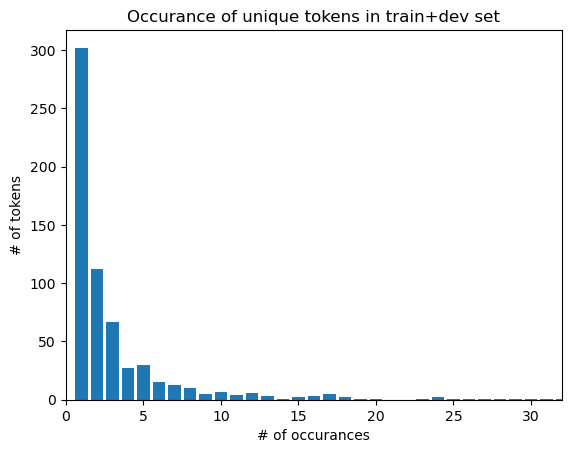

In [46]:
import matplotlib.pyplot as plt

plt.bar(x=TOKEN_COUNT_X, height=NUM_TOKENS_Y)
plt.title("Occurance of unique tokens in train+dev set")
plt.xlabel("# of occurances")
plt.ylabel("# of tokens")
plt.xlim(0, MAX_COUNT);

In [43]:
UNCOMMON_TOKENS_COUNT = 5

chars_with_infrequent_occurance = set()
for count in range(1, UNCOMMON_TOKENS_COUNT + 1):
    if count in train_counts:
        token_list = train_counts[count]
        chars_with_infrequent_occurance.update(set(token_list))

print(f"Number of tokens with <= {UNCOMMON_TOKENS_COUNT} occurances : {len(chars_with_infrequent_occurance)}")

Number of tokens with <= 5 occurances : 448


### Remove Out-of-Vocabulary tokens from the test set

Previously we counted the set of Out-of-Vocabulary tokens that exist in the test set but not in the train or dev set. Now, let's remove them.

In [52]:
all_tokens = set.union(train_dev_set, test_set)
print(f"Original train+dev+test vocab size : {len(all_tokens)}")

extra_hangul = set(test_oov)
train_token_set = all_tokens - extra_hangul
print(f"New train vocab size : {len(train_token_set)}")

Original train+dev+test vocab size : 508
New train vocab size : 475


### Process Hangul

In [60]:
perform_normalization = True
PERFORM_NORMALIZATION = bool(perform_normalization)

In [61]:
# import unicodedata
# def process_hangul(text):
#     normalized_text = unicodedata.normalize('NFD', text)
#     normalized_text = normalized_text.replace("\u3099", "").replace("\u309A", "")
#     return normalized_text

In [62]:
# if PERFORM_NORMALIZATION:
#     normalized_train_token_set = set()
#     for token in train_token_set:
#         normalized_token = process_hangul(str(token))
#         normalized_train_token_set.update(normalized_token)
        
#     print(f"After hangul normalization, number of train tokens : {len(normalized_train_token_set)}")
# else:
#     normalized_train_token_set = train_token_set

### Process special character tokens

There are several tokens which do not accurately correspond to an acoustic feature. A few examples are various commas and the period. Think of it this way, unless every sentence ends with a period (and this is uncommon - since training datasets are often comprised of small snippets of audio out of a longer conversations), then a model has insufficient context to determine when to end a sentence from just the snippet it was provided.

As such, we remove several special tokens such as commas, question marks, periods, quotation marks, and a few special tokens sometimes used in Japanese text.

In [63]:
# Preprocessing steps
import re
import unicodedata

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\…\{\}\【\】\・\。\『\』\、\ー\〜]'  # remove special character tokens
hangul_removal_regex = '[' + "".join([f"\{token}" for token in extra_hangul]) + ']'  # remove test set kanji


def remove_special_characters(data):
    data["text"] = re.sub(chars_to_ignore_regex, '', data["text"]).lower().strip()
    return data

def remove_extra_hangul(data):
    data["text"] = re.sub(hangul_removal_regex, '', data["text"])
    return data

def remove_hangul(data):
    # perform dakuten normalization (if it was requested)
    if PERFORM_NORMALIZATION:
        text = data['text']
        data['text'] = process_hangul(text)
    return data

### Process dataset

Now that we have the functions necessary to clean up the transcripts, let's create a small pipeline to clean up the manifest and write new manifests for us. For simplicity's sake (as the dataset is so small), a simple sequential pipeline will be sufficient for our use case.

In [67]:
# Processing pipeline
def apply_preprocessors(manifest, preprocessors):
    for processor in preprocessors:
        for idx in tqdm(range(len(manifest)), desc=f"Applying {processor.__name__}"):
            manifest[idx] = processor(manifest[idx])

    print("Finished processing manifest !")
    return manifest

In [68]:
# List of pre-processing functions
PREPROCESSORS = [
    remove_special_characters,
    remove_extra_hangul,
    # remove_hangul,
]

In [69]:
# Load manifests
train_data = read_manifest(train_manifest)
dev_data = read_manifest(dev_manifest)
test_data = read_manifest(test_manifest)

# Apply preprocessing
train_data_processed = apply_preprocessors(train_data, PREPROCESSORS)
dev_data_processed = apply_preprocessors(dev_data, PREPROCESSORS)
test_data_processed = apply_preprocessors(test_data, PREPROCESSORS)

# Write new manifests
train_manifest_cleaned = write_processed_manifest(train_data_processed, train_manifest)
dev_manifest_cleaned = write_processed_manifest(dev_data_processed, dev_manifest)
test_manifest_cleaned = write_processed_manifest(test_data_processed, test_manifest)

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Applying remove_special_characters:   0%|          | 0/93 [00:00<?, ?it/s]

Applying remove_extra_hangul:   0%|          | 0/93 [00:00<?, ?it/s]

Finished processing manifest !


Applying remove_special_characters:   0%|          | 0/29 [00:00<?, ?it/s]

Applying remove_extra_hangul:   0%|          | 0/29 [00:00<?, ?it/s]

Finished processing manifest !


Applying remove_special_characters:   0%|          | 0/28 [00:00<?, ?it/s]

Applying remove_extra_hangul:   0%|          | 0/28 [00:00<?, ?it/s]

Finished processing manifest !


Writing manifest data:   0%|          | 0/93 [00:00<?, ?it/s]

Finished writing manifest: /home/ec2-user/SageMaker/dataset/common-voice-dataset/manifests/ko/commonvoice_train_manifest_processed.json


Writing manifest data:   0%|          | 0/29 [00:00<?, ?it/s]

Finished writing manifest: /home/ec2-user/SageMaker/dataset/common-voice-dataset/manifests/ko/commonvoice_dev_manifest_processed.json


Writing manifest data:   0%|          | 0/28 [00:00<?, ?it/s]

Finished writing manifest: /home/ec2-user/SageMaker/dataset/common-voice-dataset/manifests/ko/commonvoice_test_manifest_processed.json


### Final character set

After pre-processing the dataset, let's recover the final character set used to train the models.

In [70]:
train_manifest_data = read_manifest(train_manifest_cleaned)
train_charset = get_charset(train_manifest_data)

dev_manifest_data = read_manifest(dev_manifest_cleaned)
dev_charset = get_charset(dev_manifest_data)

train_dev_set = set.union(set(train_charset.keys()), set(dev_charset.keys()))

Reading manifest data: 0it [00:00, ?it/s]

Computing character set:   0%|          | 0/93 [00:00<?, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Computing character set:   0%|          | 0/29 [00:00<?, ?it/s]

In [71]:
print(f"Number of tokens in preprocessed train+dev set : {len(train_dev_set)}")

Number of tokens in preprocessed train+dev set : 470


## Processing job

In [59]:
from sagemaker.pytorch import PyTorch
from sagemaker.processing import Processor, ScriptProcessor, FrameworkProcessor

In [71]:
experiment_name = 'nemo-exp1'

processing_instance_type = 'ml.m5.xlarge'
processing_instance_type='local'

In [61]:
image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=sagemaker_session.boto_region_name,
    version="1.13.1",
    py_version="py39",
    image_scope='training',
    instance_type=processing_instance_type,
)

In [62]:
if processing_instance_type =='local':
    from sagemaker.local import LocalSession
    import os
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
else:
    sagemaker_session = sagemaker.Session()

In [63]:
bucket = sagemaker_session.default_bucket()
prefix = 'nemo-test'
code_location = f's3://{bucket}/{prefix}/backup_codes'
output_path = f's3://{bucket}/{prefix}/model_output' 
s3_log_path = f's3://{bucket}/{prefix}/logs'

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [73]:
s3_source_path = 's3://dataset-us-west-2-cyj/commonvoice'
processing_output = f's3://{bucket}/commonvoice/output'

In [74]:
nemo_processor = FrameworkProcessor(
    PyTorch,
    framework_version="1.13.1",
    role=role, 
    image_uri=image_uri,
    instance_count=1,
    instance_type=processing_instance_type,
    code_location=code_location
    )

In [ ]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

nemo_processor.run(
    code="nemo_processing.py",
    source_dir=os.getcwd() + "/scripts/preprocessing/",
    inputs=[
        ProcessingInput(source=s3_source_path, input_name="commonvoice", destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output", destination=processing_output),
    ],
    # arguments=["--img", "640", "--conf", "0.25", "--source", "/opt/ml/processing/input", "--weights", "/opt/ml/processing/weights/model.tar.gz", "--project", "/opt/ml/processing/output"],
    job_name=job_name,
    experiment_config={
      'TrialName': job_name,
      'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.processing:Uploaded /home/ec2-user/SageMaker/2023/training-code/Nvidia-NeMo/scripts/preprocessing/ to s3://sagemaker-us-west-2-322537213286/nemo-test/backup_codes/nemo-exp1-0308-10451678272312/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-west-2-322537213286/nemo-test/backup_codes/nemo-exp1-0308-10451678272312/source/runproc.sh
INFO:sagemaker:Creating processing-job with name nemo-exp1-0308-10451678272312
INFO:sagemaker.local.local_session:Starting processing job


## Set Up Hyperparameters, Metric Definitions, and MPI Options
The following `hyperparameters` dictionary is to pass arguments to the training script (`train_gptj_simple.py`) and set the model parallel configuration when creating the training job.

You can also add custom mpi flags. By default, we have `--mca btl_vader_single_copy_mechanism none` to remove unnecessary logs.

Next we add a base metric definitions to enable the metric upload in SageMaker. You can add any further metric definitions.

In [ ]:
metric_definitions=[
     {"Name": "train_runtime", "Regex": "train_runtime.*=\D*(.*?)$"},
     {'Name': 'train_samples_per_second', 'Regex': "train_samples_per_second.*=\D*(.*?)$"},
     {'Name': 'epoch', 'Regex': "epoch.*=\D*(.*?)$"},
     {'Name': 'f1', 'Regex': "f1.*=\D*(.*?)$"},
     {'Name': 'exact_match', 'Regex': "exact_match.*=\D*(.*?)$"}]

In [8]:
hyperparameters = {
    'config' : '/opt/ml/code/config/train_cord-sm.yaml',
    'pretrained_model_name_or_path' : 'naver-clova-ix/donut-base',
    # 'dataset_name_or_paths' : '["naver-clova-ix/cord-v2"]',
    'exp_version' : 'test_experiment'
}

hyperparameters

{'config': '/opt/ml/code/config/train_cord-sm.yaml',
 'pretrained_model_name_or_path': 'naver-clova-ix/donut-base',
 'exp_version': 'test_experiment'}

Set the model configuration below.

## Specify Essential Parameters for a SageMaker Training Job

Next, you will use the [`SageMaker Estimator API`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to define a SageMaker Training Job, passing values through the following parameters for training job name, the number of EC2 instances, the instance type, and the size of the volume attached to the instances. 

* `instance_count`
* `instance_type`
* `volume_size`
* `base_job_name`

### Update the Type and Number of EC2 Instance to Use

The instance type and the number of instances you specify to the `instance_type` and `instance_count` parameters, respectively, will determine the total number of GPUs (world size).

$$ \text{(world size) = (the number of GPUs on a single instance)}\times\text{(the number of instance)}$$

To look up the number of GPUs of different instance types, see [Amazon EC2 Instance Types](https://aws.amazon.com/ec2/instance-types/). Use the section **Accelerated Computing** to see general purpose GPU instances. Note that, for example, a given instance type `p4d.24xlarge` has a corresponding instance type `ml.p4d.24xlarge` in SageMaker.
For SageMaker supported `ml` instances and cost information, see [Amazon SageMaker Pricing](https://aws.amazon.com/sagemaker/pricing/). 

### Set distributed training

In [11]:
distribution = {}

use_smddp = True
flag = 'smddp' if use_smddp else None

if use_smddp or flag == 'smddp':
    distribution["smdistributed"]={ 
                        "dataparallel": {
                            "enabled": True
                        }
                }

elif flag == 'smmp':
    distribution['smdistributed'] = {
        "modelparallel": {
            "enabled":True,
            "parameters": {
                "ddp": True,
                "microbatches": 2,
                "placement_strategy": "spread",
                "pipeline": "interleaved",
                "optimize": "speed",
                "partitions": 1,
                "tensor_parallel_degree" : 8,  ## 무려 400 MB 줄임?
                "fp16" : True,
                "fp16_params" : True,
                "shard_optimizer_state" : True,  ## 무려 32GB 를 줄임
                # parameters for sharded data parallelism
#                 "sharded_data_parallel_degree": 2,              # Add this to activate sharded data parallelism
#                 "sdp_reduce_bucket_size": int(5e8),             # Optional
#                 "sdp_param_persistence_threshold": int(1e6),    # Optional
#                 "sdp_max_live_parameters": int(1e9),            # Optional
#                 "sdp_hierarchical_allgather": True,             # Optional
#                 "sdp_gradient_clipping": 1.0                    # Optional
            }
        }   
    }
    mpioptions = "-x NCCL_DEBUG=WARN -x SMDEBUG_LOG_LEVEL=ERROR "
    mpioptions += "-x SMP_DISABLE_D2D=1 -x SMP_D2D_GPU_BUFFER_SIZE_BYTES=1 -x SMP_NCCL_THROTTLE_LIMIT=1 "
    mpioptions += "-x FI_EFA_USE_DEVICE_RDMA=1 -x FI_PROVIDER=efa -x RDMAV_FORK_SAFE=1"

    distribution["mpi"]={
        "enabled": True,
        "processes_per_host": 8, # Pick your processes_per_host
        "custom_mpi_options": mpioptions      
    }
    
elif flag == 'smmp-sharedddp':
    distribution['smdistributed'] = {
        "modelparallel": {
            "enabled":True,
            "parameters": {
                "partitions" : 1,
#                 "pipeline_parallel_degree": 1,    # Optional, default is 1
                # "tensor_parallel_degree": 1,      # Optional, default is 1
                "ddp": True,
                "bf16" : True,
                # parameters for sharded data parallelism
                "sharded_data_parallel_degree": 2,              # Add this to activate sharded data parallelism
                "sdp_reduce_bucket_size": int(5e8),             # Optional
                "sdp_param_persistence_threshold": int(1e6),    # Optional
                "sdp_max_live_parameters": int(1e9),            # Optional
                "sdp_hierarchical_allgather": True,             # Optional
                "sdp_gradient_clipping": 1.0                    # Optional     
            }
        }   
    }
    mpioptions = "-x NCCL_DEBUG=WARN -x SMDEBUG_LOG_LEVEL=ERROR "
    mpioptions += "-x SMP_DISABLE_D2D=1 -x SMP_D2D_GPU_BUFFER_SIZE_BYTES=1 -x SMP_NCCL_THROTTLE_LIMIT=1 "
    mpioptions += "-x FI_EFA_USE_DEVICE_RDMA=1 -x FI_PROVIDER=efa -x RDMAV_FORK_SAFE=1"


    distribution["mpi"]={
        "enabled": True,
        "processes_per_host": 8, # Pick your processes_per_host
        "custom_mpi_options": mpioptions      
    }
else:
    distribution["mpi"]={"enabled": False}
    
# if not use_smddp:
#     distribution = {}

### Use local mode / Script mode setting

In [12]:
# experiment_name = 'nemo-exp1'
# instance_type = 'ml.p3.16xlarge'  # 'ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge', 'local_gpu'
instance_type = 'local_gpu'
instance_count = 1
do_spot_training = False
max_wait = None
max_run = 1*60*60

In [13]:
# local_cache_dir = f'/home/ubuntu/workspace/datasets/cord-v2' ## ec2
local_cache_dir = f'/home/ec2-user/SageMaker/concept-caption-dataset/cord-v2' ##SageMaker
s3_cache_dir = f's3://{bucket}/cache_dir'

In [14]:
# !aws s3 sync $local_cache_dir $s3_cache_dir

In [15]:
kwargs = {}
checkpoint_s3_uri = None

if instance_type =='local_gpu':
    from sagemaker.local import LocalSession
    import os
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    data_channels = {"cache_dir": f'file://{local_cache_dir}'}
    
else:
    sagemaker_session = sagemaker.Session()

    if use_fsx:
        # Use the security group and subnet that was used to create the fsx filesystem
        kwargs["security_group_ids"] = ["sg-0bc738570daec9015"]  ## 학습인스턴스 용 보안그룹
        kwargs["subnets"] = ["subnet-02e36c042e58264e6"]       ## FSX 생성 시 설정한 동일 subnet

    data_channels = {"cache_dir": s3_cache_dir}



### Create a SageMaker HuggingFace Estimator

The following cell constructs a PyTorch estimator using the parameters defined above.

In [16]:
print("experiment_name : {} \ntrain_instance_type : {} \ntrain_instance_count : {} \ndistribution : {}".format(experiment_name, instance_type, instance_count, distribution))    

experiment_name : nemo-exp1 
train_instance_type : local_gpu 
train_instance_count : 1 
distribution : {'smdistributed': {'dataparallel': {'enabled': True}}}


In [17]:
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

In [28]:
if use_smddp:
    entry_point="sm_train.py"
    entry_point="setup.py"
else:
    entry_point="train.py"


smp_estimator = PyTorch(
        entry_point=entry_point,
        source_dir=os.getcwd() + '/NeMo',
        role=role,
        instance_type=instance_type,
        instance_count=instance_count,
#         image_uri=image_uri,
        # volume_size=volume_size,
        sagemaker_session=sagemaker_session,
        distribution=distribution,
        framework_version='1.13.1',
        py_version='py39',
        code_location = code_location,
        output_path=output_path,
        disable_profiler=True,
        debugger_hook_config=False,
        checkpoint_s3_uri=checkpoint_s3_uri,
        metric_definitions=metric_definitions,
        enable_sagemaker_metrics=True,
        hyperparameters=hyperparameters,
        max_run=max_run,
        tags=[{'Key':'email','Value':'choijoon@amazon.com'}],
#         compiler_config=TrainingCompilerConfig(),
#         keep_alive_period_in_seconds=600,
        **kwargs
    )

entry_point

'setup.py'

Finally, run the estimator to launch the SageMaker training job of GPT-J model with tensor parallelism.

In [29]:
data_channels

{'cache_dir': 'file:///home/ec2-user/SageMaker/concept-caption-dataset/cord-v2'}

In [30]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

if instance_type =='local_gpu':
    smp_estimator.checkpoint_s3_uri = None
else:
    smp_estimator.checkpoint_s3_uri = f's3://{bucket}/checkpoints/'
hyperparameters['job_name'] = f'{job_name}'

smp_estimator.fit(
    inputs=data_channels, 
    job_name=job_name,
    experiment_config={
      'TrialName': job_name,
      'TrialComponentDisplayName': job_name,
    },
    wait=False,
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: nemo-exp1-0302-02461677725193
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.local.image:Using the long-lived AWS credentials found in session
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-627ek:
    command: train
    container_name: 91u3imwapq-algo-1-627ek
    deploy:
      resources:
        reservations:
          devices:
          - capabilities:
            - gpu
    environment:
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    i

Login Succeeded


INFO:sagemaker.local.image:image pulled: 763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:1.13.1-gpu-py39


Creating 91u3imwapq-algo-1-627ek ... 
Creating 91u3imwapq-algo-1-627ek ... done
Attaching to 91u3imwapq-algo-1-627ek
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,454 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,521 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,530 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,533 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,537 sagemaker_pytorch_container.training INFO     Invoking SMDataParallel
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,537 sagemaker_pytorch_container.training INFO     Invoking user training script.
91u3imwapq-algo-1-627ek | 2023-03-02 02:50:30,538 sagemaker-training-toolkit I

RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpk70stqme/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1

In [ ]:
job_name=smp_estimator.latest_training_job.name

In [49]:
sagemaker_session = sagemaker.Session()
sagemaker_session.logs_for_job(job_name=job_name, wait=True)

2023-01-18 07:05:56 Starting - Starting the training job.

KeyboardInterrupt: 

# Accessing the Training Logs

You can access the training logs from [Amazon CloudWatch](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/WhatIsCloudWatch.html). Make sure to look at the logs of algo-1 as that is the master node whose output stream will have the training job logs.

You can use CloudWatch to track SageMaker GPU and memory utilization during training and inference. To view the metrics and logs that SageMaker writes to CloudWatch, see *Processing Job, Training Job, Batch Transform Job, and Endpoint Instance Metrics* in [Monitor Amazon SageMaker with Amazon CloudWatch](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html).

If you are a new user of CloudWatch, see [Getting Started with Amazon CloudWatch](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/GettingStarted.html). 

For additional information on monitoring and analyzing Amazon SageMaker training jobs, see [Monitor and Analyze Training Jobs Using Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html).

# Deploying Trained Model for Inference

In most cases the trained model can be deployed on a single device for inference, since inference has smaller memory requirements. You can use the SMP API to create a single, unified model after training. For TensorFlow, a SavedModel can be created using `smp.DistributedModel.save_model` API, and for PyTorch, `smp.save()` can be used.

After you build and train your models, you can deploy them to get predictions in one of two ways:

* To set up a persistent endpoint to get predictions from your models, use SageMaker hosting services. For an overview on deploying a single model or multiple models with SageMaker hosting services, see [Deploy a Model on SageMaker Hosting Services](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-deployment.html#how-it-works-hosting).
* To get predictions for an entire dataset, use SageMaker batch transform. For an overview on deploying a model with SageMaker batch transform, see [Get Inferences for an Entire Dataset with Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html).

To learn more about deploying models for inference using SageMaker, see [Deploy Models for Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html). 


In [381]:
!rm model.tar.gz
!tar czvf model.tar.gz {src_dir}

model_result/
model_result/trainer_state.json
model_result/rng_state_9.pth
model_result/tokenizer_config.json
model_result/rng_state_5.pth
model_result/rng_state_13.pth
model_result/optimizer.pt_0_6_0.pt
model_result/rng_state_3.pth
model_result/user_content.pt
model_result/special_tokens_map.json
model_result/rng_state_11.pth
model_result/optimizer.pt_0_3_0.pt
model_result/scheduler.pt
model_result/rng_state_15.pth
model_result/rng_state_10.pth
model_result/optimizer.pt_0_5_0.pt
model_result/optimizer.pt_0_1_0.pt
model_result/rng_state_7.pth
model_result/optimizer.pt_0_4_1.pt
model_result/training_args.bin
model_result/optimizer.pt_0_3_1.pt
model_result/rng_state_0.pth
model_result/optimizer.pt_0_2_0.pt
model_result/tokenizer.json
model_result/optimizer.pt_0_1_1.pt
model_result/rng_state_4.pth
model_result/rng_state_6.pth
model_result/optimizer.pt_0_6_1.pt
model_result/rng_state_2.pth
model_result/optimizer.pt_0_7_1.pt
model_result/rng_state_1.pth
model_result/optimizer.pt_0_5_1.pt
mo